In [1]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx
import qiskit_optimization as qco


In [2]:

from qiskit import Aer

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp #read docs on this
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

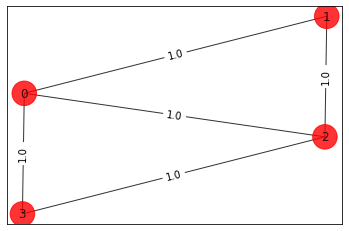

In [3]:
# Generating a graph of 4 nodes

n=4 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [4]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


In [5]:
# Porting my graph generator
def G(n, seed, probability, sparse=True, w=None, r=True):
    """
    Generates a seeded random graph with n nodes. 
    probability between 0 and 1 to increase odds.
    sparse means if we want a sparse or dense graph.
    w is the weight of the edges if wanted.
    r means if we want random weights or not.
    """
    random.seed(seed)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i, j in itertools.combinations(G.nodes, 2):
        if sparse == True:
            if random.random() > (1 - probability):
                if r == True:
                    G.add_edge(i, j, weight=random.random())
                else:
                    G.add_edge(i, j, weight=w)
        if sparse == False:
            #Means we want a dense network, so
            if r == True:
                G.add_edge(i, j, weight=random.random())
            else:
                G.add_edge(i, j, weight=w)
    return G

In [7]:
import random
import itertools
GG = G(10, 1, 0.5, sparse=True, w=1, r=False)
adjacency = nx.adjacency_matrix(GG).todense()
b = np.zeros(GG.number_of_nodes())
Q = adjacency

In [11]:
#Solving via brute force
n = 10
w = Q
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

case = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 0
case = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 4
case = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 3
case = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 7
case = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 5
case = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 7
case = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0] cost = 8
case = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0] cost = 10
case = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] cost = 3
case = [1, 0, 0, 1, 0, 0, 0, 0, 0, 0] cost = 5
case = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 4
case = [1, 1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 6
case = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0] cost = 6
case = [1, 0, 1, 1, 0, 0, 0, 0, 0, 0] cost = 6
case = [0, 1, 1, 1, 0, 0, 0, 0, 0, 0] cost = 7
case = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0] cost = 7
case = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] cost = 1
case = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0] cost = 5
case = [0, 1, 0, 0, 1, 0, 0, 0, 0, 0] cost = 4
case = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0] cost = 8
case = [0, 0, 1, 0, 1, 0, 0, 0, 0, 0] cost = 4
case = [1, 0

In [22]:
#Qiskit has an ising hamiltonian generator!
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: -2.5
Ising Hamiltonian:
IIZZ	(0.5+0j)
IZIZ	(0.5+0j)
IZZI	(0.5+0j)
ZIIZ	(0.5+0j)
ZZII	(0.5+0j)



In [23]:
#Ising Hamiltonian to "Quadratic Program" (need to read their api on this)
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;

minimize
 [ - 3 x_0^2 + 2 x_0*x_1 + 2 x_0*x_2 + 2 x_0*x_3 - 2 x_1^2 + 2 x_1*x_2
 - 3 x_2^2 + 2 x_2*x_3 - 2 x_3^2 ];
 
subject to {

}


In [24]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

optimal function value: -4.0
optimal value: [1. 0. 1. 0.]
status: SUCCESS


energy: -1.5
max-cut objective: -4.0
solution: [0 1 0 1]
solution objective: 4.0


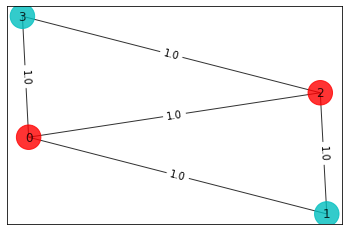

In [25]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)



In [26]:
# Now, solving with Variational Quantum Eigensolver
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -1.4999796718929863
time: 4.200237512588501
max-cut objective: -3.9999796718929863
solution: [1. 0. 1. 0.]
solution objective: 4.0


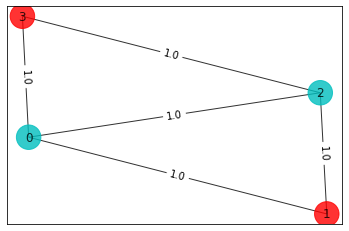

In [27]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.run(quantum_instance)

# print results
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

# plot results
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)